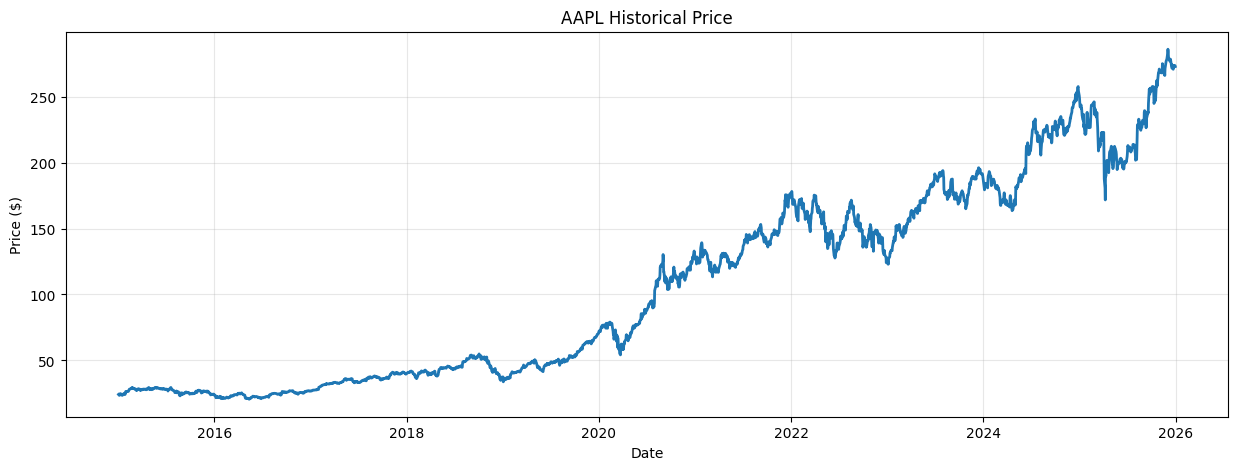


--------------------------------------------------
BACKTEST RESULTS
--------------------------------------------------
Strategy Return: 88.43%
Buy & Hold Return: 576.91%
Number of Trades: 260
Max Drawdown: -31.78%
--------------------------------------------------


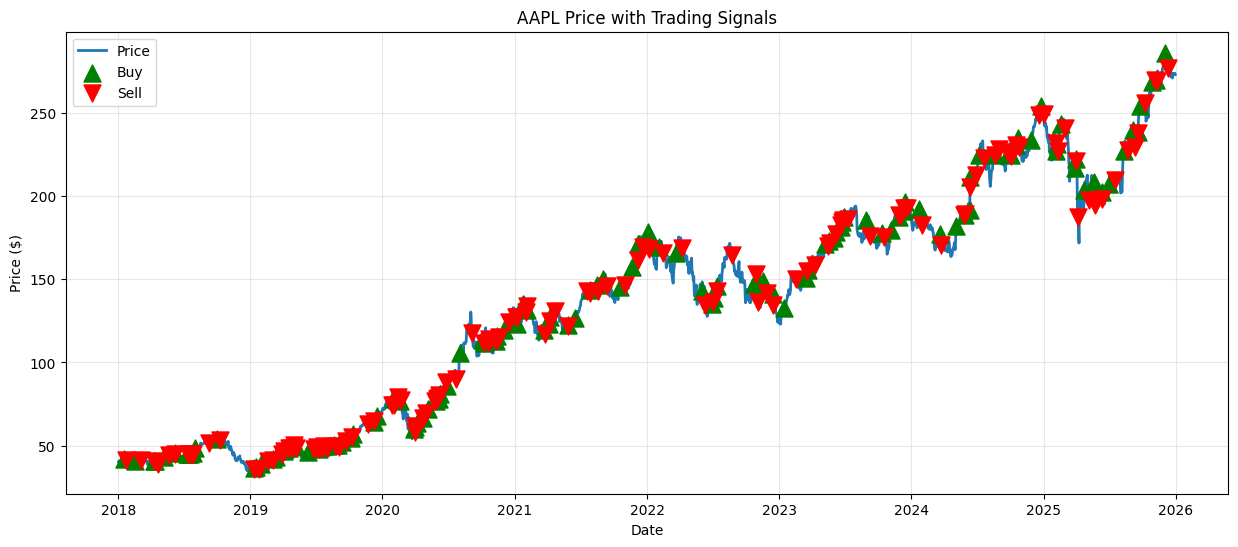

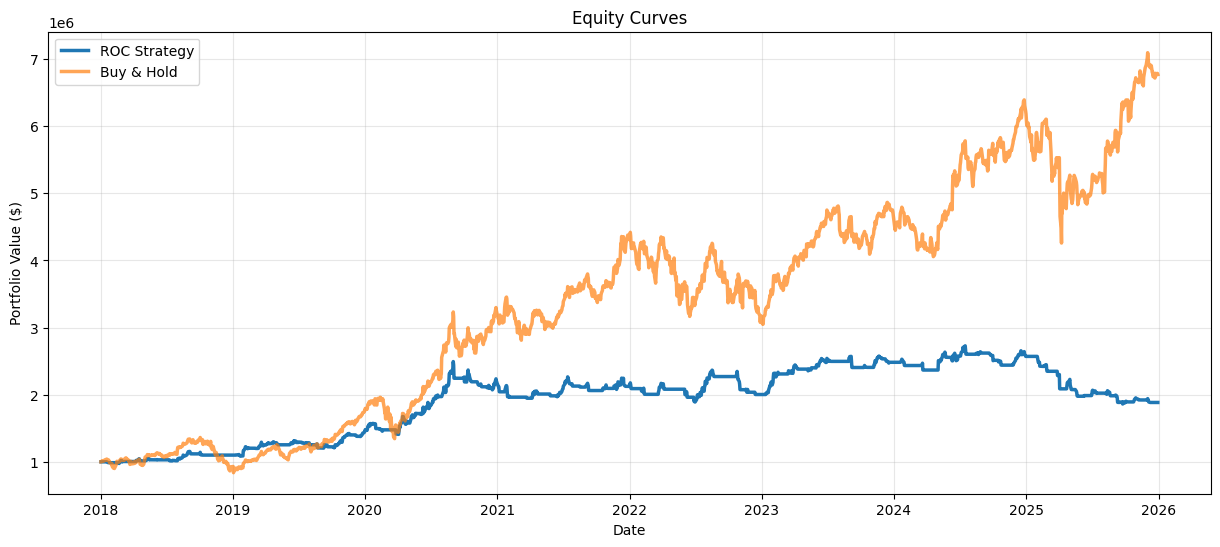

In [1]:

import yfinance as yf 
import pandas as pd
import matplotlib.pyplot as plt
from backtest_function import run_backtest
# print quick price chart for appl
initial_data = yf.download('AAPL', start='2015-01-01', end='2025-12-31', progress=False)
plt.figure(figsize=(15, 5))
plt.plot(initial_data.index, initial_data['Close'], linewidth=2)
plt.title('AAPL Historical Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(alpha=0.3)
plt.show()
#create roc strategy function
def roc_strategy(prices: pd.Series, data: pd.DataFrame, params: dict) -> pd.Series:
    "Generate ROC signals: 1 = long, 0 = cash"
    roc_n = params.get('roc_n', 10) #10 day period - play around with this to see how it affects performance
    roc_threshold = params.get('roc_threshold', 3.0) #3% threshold, play around
    
    roc = ((prices - prices.shift(roc_n)) / prices.shift(roc_n)) * 100
    signal = (roc > roc_threshold).astype(int) # create series of true/false based on ROC to threshold, true =1,false = 0
    return signal

# run backtest
params = {'roc_n': 10, 'roc_threshold': 3.0} # dictionary of parameters to pass to strategy

trade_result = run_backtest(
    ticker='AAPL',
    start='2018-01-01', # can change these as well
    end='2025-12-31',
    strategy_fn=roc_strategy, #use strat function just created to decide when to be long or in cash
    strategy_params=params
)

# deliverables
total_return = (trade_result.results['ending_value_strategy'] / trade_result.results['initial_capital'] - 1) * 100
buyhold_return = (trade_result.results['ending_value_buyhold'] / trade_result.results['initial_capital'] - 1) * 100
num_trades = int(trade_result.results['trades'])
#just fetching the relevant metrics from the backtest results to print out in a nice format

print("\n" + "-"*50)
print("BACKTEST RESULTS")
print("-"*50)
print(f"Strategy Return: {total_return:.2f}%")
print(f"Buy & Hold Return: {buyhold_return:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Max Drawdown: {trade_result.results['max_drawdown_strategy']*100:.2f}%")
print("-"*50)

# Price Signals Plot
buy = trade_result.position.diff() == 1
sell = trade_result.position.diff() == -1

plt.figure(figsize=(15, 6))
plt.plot(trade_result.prices.index, trade_result.prices, label='Price', linewidth=2)
plt.scatter(trade_result.prices[buy].index, trade_result.prices[buy], 
           marker='^', color='green', s=150, label='Buy', zorder=5)
plt.scatter(trade_result.prices[sell].index, trade_result.prices[sell],
           marker='v', color='red', s=150, label='Sell', zorder=5)
#formatted more
plt.title('AAPL Price with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# equity chart
plt.figure(figsize=(15, 6))
plt.plot(trade_result.equity_strategy.index, trade_result.equity_strategy, 
         label='ROC Strategy', linewidth=2.5)
plt.plot(trade_result.equity_buyhold.index, trade_result.equity_buyhold,
         label='Buy & Hold', linewidth=2.5, alpha=0.7)
plt.title('Equity Curves')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



 ## Conclusions and Insights

The Rate of Change (ROC) indicator measures the percentage price change over the past 10 days, capturing short-term momentum by comparing today's price to the price 10 trading days ago. The strategy enters a long position when ROC exceeds 3%, signaling strong upward momentum, and exits to cash when ROC falls below 3%, indicating weakening or negative momentum. This strategy exploits investor underreaction and herding behavior when prices begin rising, information diffuses slowly through the market, and momentum builds as more investors observe the trend and pile in, creating self-reinforcing continuation patterns.

The strategy however has several limitations: it assumes momentum persists long enough to profit but is vulnerable to sharp reversals during trend breakdowns. We ignore transaction costs and slippage, which would reduce real-world returns with frequent trading. The 10-day lookback and 3% threshold are arbitrary parameters not optimized for different market conditions. This long-only approach cannot profit from downward momentum i.e short selling, and the backtest suffers from survivorship bias by testing only on AAPL, a successful stock.